In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from gensim.models import Word2Vec
import datetime
from dateutil.relativedelta import relativedelta
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
train=pd.read_csv("Training_set.csv")

In [3]:
test=pd.read_csv("Test_set.csv")

In [4]:
train.iloc[0]

Unnamed: 0                                                                              0
user_id                                                                             98304
job_id                                                                               3163
employer_id                                                                           208
job_opening_date                                                               2017-10-01
job_closing_date                                                               2018-11-19
job_description                         <h2 style="margin-left: 0px !important;">Overv...
job_type                                                                                1
job_title                                                      UK Sales Graduate Job 2019
employer_title                                                                        P&G
employer_description                    <p>Nearly five billion times a day, P&amp;G br...
employer_s

In [5]:
def get_job_info(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        job_sector_title=data["job_sector_title"]
        description=data["job_description"]
        em_title=data["employer_title"]
        em_sector_title=data["employer_sector_title"]
        em_description=data["employer_description"]
        a=""
        a+=title+" "
        a+=job_sector_title+" "
        a+=description+" "
        a+=em_title+" "
        a+=em_sector_title+" "
        a+=em_description+" "
        job_info.append(a)
    return job_info

In [6]:
train_job_info=get_job_info(train)

In [7]:
def clean(x):
    res=[]
    for content in x:
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("&#39;","")
        content=content.replace("&nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ")
        content=content.replace("&rsquo;","").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        content=content.split(" ")
        y=[]
        for i in content:
            if len(i)>1:
                y.append(i.lower())
        res.append(y)
    return res

In [8]:
cleaned_train_job_info=clean(train_job_info)

In [9]:
cleaned_train_job_info[100]

['graduate',
 'consultant',
 'climate',
 'change',
 'cities',
 'technology',
 'consulting',
 'project',
 'management',
 'at',
 'arup',
 'we',
 'are',
 'passionate',
 'about',
 'designing',
 'and',
 'delivering',
 'ground-breaking',
 'work',
 'in',
 'infrastructure',
 'building',
 'design',
 'and',
 'specialist',
 'technical',
 'services',
 'independent',
 'in',
 'ownership',
 'and',
 'spirit',
 'we',
 'are',
 'global',
 'firm',
 'of',
 'designers',
 'planners',
 'engineers',
 'consultants',
 'and',
 'technical',
 'experts',
 'using',
 'our',
 'skills',
 'to',
 'help',
 'shape',
 'better',
 'world',
 'our',
 'energy',
 'climate',
 'change',
 'and',
 'cities',
 'consulting',
 'team',
 'in',
 'london',
 'is',
 'multi-disciplinary',
 'team',
 'of',
 'engineers',
 'policy',
 'experts',
 'and',
 'environmental',
 'scientists',
 'who',
 'focus',
 'on',
 'the',
 'challenges',
 'and',
 'opportunities',
 'of',
 'energy',
 'climate',
 'change',
 'and',
 'cities',
 'our',
 'areas',
 'of',
 'busine

In [10]:
def remove_stopwords(x):
    res=[]
    with open('stopwords.txt') as stopfile:
        stopwords = stopfile.read()
        stop = stopwords.split()
    for i,job in enumerate(x):
        a=[]
        for word in job:
            if word not in stop:
                a.append(word)
        res.append(a)
    return res

In [11]:
train_clean=remove_stopwords(cleaned_train_job_info)

In [12]:
train_clean[0]

['uk',
 'sales',
 'graduate',
 'job',
 '2019',
 'sales',
 'commercial',
 'overview',
 'want',
 'work',
 'brands',
 'millions',
 'consumers',
 'live',
 'without',
 'want',
 'work',
 'like-minded',
 'talented',
 'colleagues',
 'motivated',
 'challenging',
 'problems',
 'real',
 'responsibility',
 'winning',
 'perfect',
 'opportunity',
 'apply',
 'now',
 'join',
 'p&g',
 'sales',
 'team',
 'expect',
 'working',
 'sales',
 'p&g',
 'means',
 'getting',
 'multi',
 'million',
 'pound',
 'business',
 'budget',
 'lead',
 'day',
 'means',
 'working',
 'great',
 'brands',
 'like',
 'pampers',
 'fairy',
 'gillette',
 'uk',
 'biggest',
 'grocery',
 'retailers',
 'will',
 'key',
 'contact',
 'business',
 'retailer',
 'responsible',
 'building',
 'maintaining',
 'relationship',
 'will',
 'build',
 'design',
 'ideas',
 'strategies',
 'using',
 'analytics',
 'shopper',
 'insights',
 'use',
 'relationship',
 'understanding',
 'market',
 'sell',
 'negotiate',
 'execute',
 'ideas',
 'full',
 'time',
 'hir

In [13]:
def get_occurence(x):
    res=[]
    for job in x:
        res.append(dict(Counter(job)))
    return res

In [14]:
occurences=get_occurence(train_clean)

In [23]:
occurences[0]

{'uk': 2,
 'sales': 8,
 'graduate': 2,
 'job': 3,
 '2019': 1,
 'commercial': 4,
 'overview': 1,
 'want': 3,
 'work': 6,
 'brands': 3,
 'millions': 1,
 'consumers': 1,
 'live': 1,
 'without': 1,
 'like-minded': 1,
 'talented': 1,
 'colleagues': 1,
 'motivated': 1,
 'challenging': 2,
 'problems': 1,
 'real': 3,
 'responsibility': 2,
 'winning': 1,
 'perfect': 1,
 'opportunity': 2,
 'apply': 3,
 'now': 1,
 'join': 1,
 'p&g': 13,
 'team': 2,
 'expect': 1,
 'working': 3,
 'means': 2,
 'getting': 1,
 'multi': 1,
 'million': 1,
 'pound': 1,
 'business': 5,
 'budget': 1,
 'lead': 1,
 'day': 4,
 'great': 2,
 'like': 1,
 'pampers': 1,
 'fairy': 2,
 'gillette': 2,
 'biggest': 1,
 'grocery': 1,
 'retailers': 1,
 'will': 6,
 'key': 1,
 'contact': 1,
 'retailer': 2,
 'responsible': 1,
 'building': 2,
 'maintaining': 1,
 'relationship': 2,
 'build': 1,
 'design': 1,
 'ideas': 3,
 'strategies': 1,
 'using': 1,
 'analytics': 1,
 'shopper': 1,
 'insights': 1,
 'use': 1,
 'understanding': 1,
 'market': 1

In [28]:
def get_vector(occurences, jobs, vector_size):
    vector=[]
    model = Word2Vec.load('model.bin')
    nb=len(jobs)
    for i,job in enumerate(jobs):
        if i%5000==0:
            print("progress : ",i/nb )
        res=np.zeros(vector_size,)
        n=sum(list(occurences[i].values()))
        for word in job:
            try:
                a=model[word]
            except:
                a=None
            if a is not None:
                count=occurences[i][word]
                w=count/n
                res+=w*a
        vector.append(res)
    return vector

In [66]:
X=get_vector(occurences, train_clean, 200)

progress :  0.0


C:\Users\Lassana Diabira\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if sys.path[0] == '':


progress :  0.00799130545965989
progress :  0.01598261091931978
progress :  0.02397391637897967
progress :  0.03196522183863956
progress :  0.03995652729829945
progress :  0.04794783275795934
progress :  0.05593913821761923
progress :  0.06393044367727913
progress :  0.07192174913693901
progress :  0.0799130545965989
progress :  0.08790436005625879
progress :  0.09589566551591867
progress :  0.10388697097557857
progress :  0.11187827643523846
progress :  0.11986958189489835
progress :  0.12786088735455825
progress :  0.13585219281421812
progress :  0.14384349827387802
progress :  0.15183480373353792
progress :  0.1598261091931978
progress :  0.16781741465285768
progress :  0.17580872011251758
progress :  0.18380002557217748
progress :  0.19179133103183735
progress :  0.19978263649149725
progress :  0.20777394195115714
progress :  0.21576524741081704
progress :  0.2237565528704769
progress :  0.2317478583301368
progress :  0.2397391637897967
progress :  0.2477304692494566
progress :  0.

In [87]:
X

[array([-0.02688661,  0.68136502, -1.78798198,  0.79242414, -0.15356046,
        -0.82737688,  0.5527839 , -0.88776974, -0.20708603, -1.54298468,
        -0.70541684, -0.46426814, -1.36177381,  0.52388388,  0.57440916,
        -0.50994537, -0.77765474, -1.50498622, -0.66482725,  0.60116975,
        -0.62273793,  0.99422287, -0.08431445,  1.04669999, -0.25417272,
         1.14958925,  0.31245683,  0.45876124,  0.58801396, -0.12614548,
         0.71810194,  0.55504599,  1.62938754,  1.15428381,  0.05178214,
         0.27731981,  1.17823911,  0.35341629,  0.07952706, -1.81368024,
         0.18657803, -1.16676687, -1.17905772, -0.07168766, -0.55325249,
         0.54934441, -0.96440982,  1.89452768,  0.7097871 , -1.17378947,
         0.52758218, -1.10079776,  0.77344292,  0.95392687, -1.93256486,
        -0.66166978, -1.55213658, -0.38356284,  0.85519487, -1.35053439,
         1.35475805, -0.76934768, -0.04943882,  0.6300419 ,  0.27470123,
        -0.39593465, -2.39302978,  0.66049784, -0.3

In [113]:
X_train=np.array(X)

(1, 200)

In [70]:
pca = PCA(n_components=2)
result = pca.fit_transform(X_train)

In [71]:
print(pca.explained_variance_ratio_)

[0.15216099 0.11486964]


In [72]:
def get_job_info_plot(df):
    job_info=[]
    for i in range(df.shape[0]):
        data=df.iloc[i]
        title=data["job_title"]
        em_title=data["employer_title"]
        a=""
        a+=title+" "
        a+=em_title+" "
        job_info.append(a)
    return job_info

In [73]:
infos=get_job_info_plot(train)

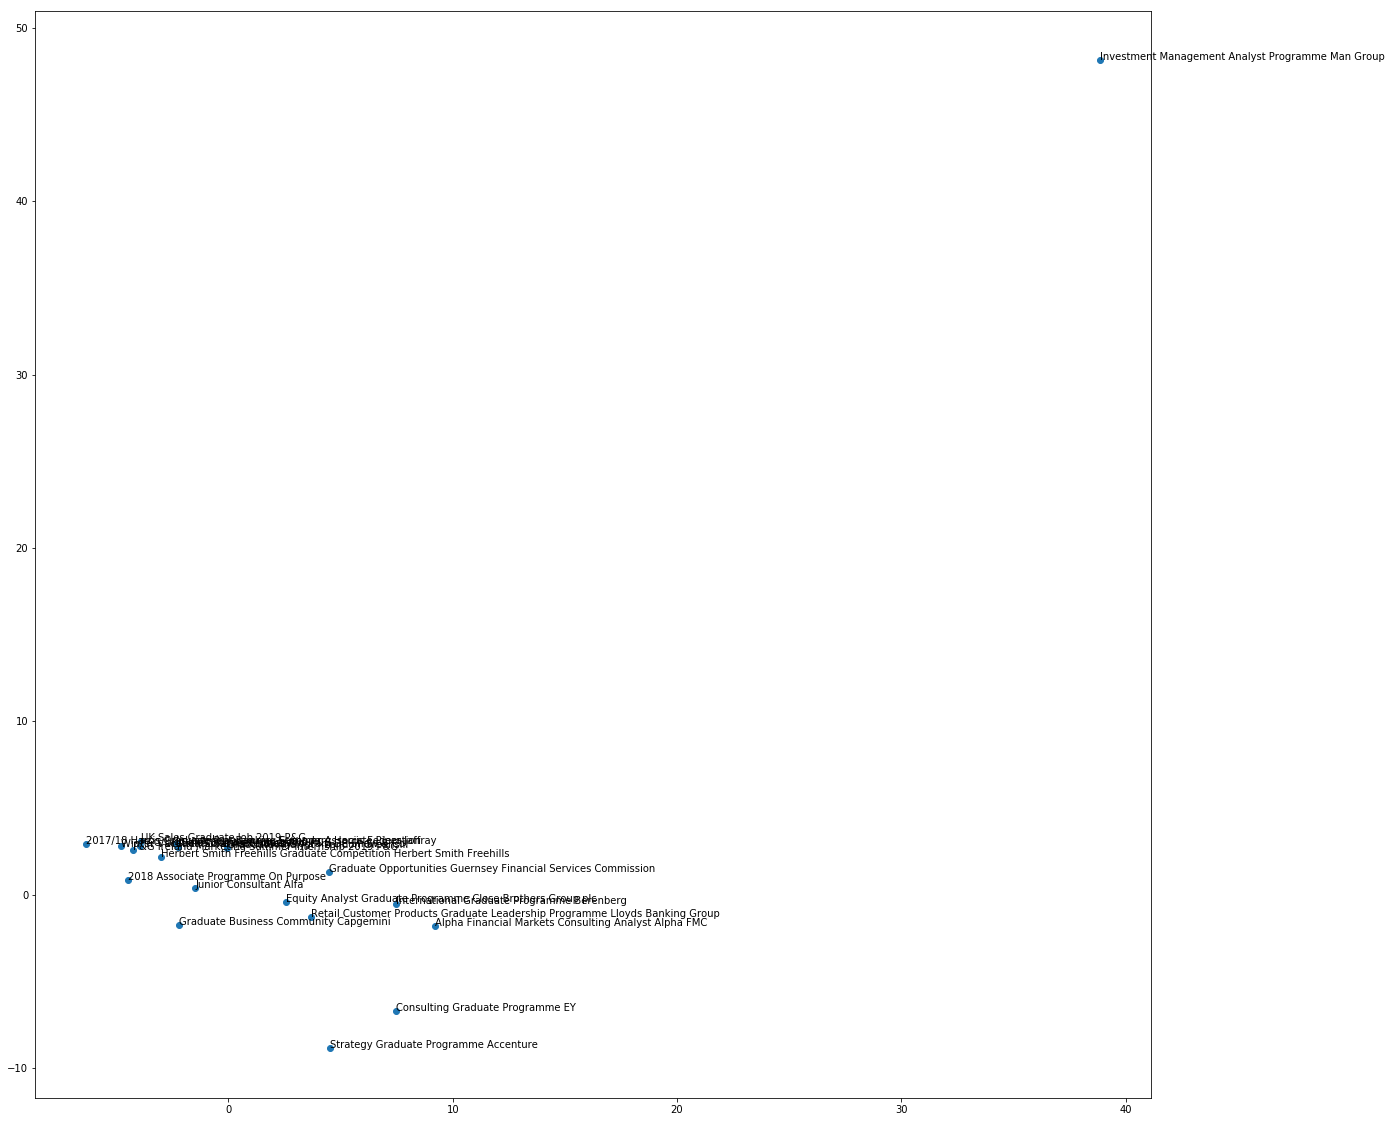

In [74]:
k=20
plt.figure(figsize=(20,20))
plt.scatter(result[:k, 0], result[:k, 1])
for i, word in enumerate(infos[:k]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))
plt.show()

In [114]:
cosine_similarity(X_train[0,:].reshape(1, -1) , X_train)

array([[1.        , 0.93035729, 0.98052574, ..., 0.38701658, 0.48999592,
        0.12166929]])

In [117]:
def clean_similarity(x):
    res=[]
    for content in x:
        content=content.replace("\r\r\n\r\r\n"," ").replace("..."," ").replace("&#39;s","").replace(":","")
        content=content.replace("&eacute;","e").replace("&lsquo;","").replace("&#39;","")
        content=content.replace("&nbsp;"," ").replace("&#39;","").replace("amp;","").replace("&middot;","")
        content=content.replace("."," ").replace(",","").replace("?"," ").replace("!","").replace("  "," ")
        content=content.replace("&rsquo;","").replace("\t"," ").replace("\r\n\r\n","").replace(" \r\n ","")
        content=content.replace("&ndash;"," ").replace("\r\n\r\n"," ").replace(" \r\n "," ").replace("\r\n"," ")
        content=content.replace("\r"," ").replace("  ","").replace("   ","").replace("  ","").replace("   ","")
        content=content.replace("(","").replace(")","").replace(" - "," ").replace(" / "," ").replace("/"," ").replace("   ","")
        content=re.sub('<.*?>',"",content , flags=re.DOTALL)
        res.append(content)
    return res

In [118]:
data_similarity=clean_similarity(train_job_info)

In [119]:
data_similarity[0]

'UK Sales Graduate Job 2019 Sales & Commercial Overview Want to work with brands that millions of consumers cant live without Want to work with like-minded and talented colleagues Are you motivated by challenging problems real responsibility and winning  If so we have the perfect opportunity for you  Apply now to join the P&G Sales team  What you can expect Working in sales at P&G means getting your own multi million pound business & budget to lead from day 1 That means working with great brands like Pampers Fairy & Gillette and the UK biggest grocery retailers You will be the key contact for the business with your retailer and responsible for building and maintaining that relationship You will build and design ideas & strategies using analytics and shopper insights and then use your relationship and understanding of the market to sell negotiate & execute your ideas  As a full time hire you are automatically enrolled in our world-class graduate scheme training programme Its 2 years of 

In [120]:
data_similarity[1]

'P&G Ireland Marketing Summer Internship 2019 Consumer FMCG & Retail Overview Want to work with brands that millions of consumers cant live without Are you ready to gain real work experience with the largest Consumer Goods Company in the world while still at university and set the path for your future career  Then we have the perfect opportunity for you Come and do our Marketing Summer Internships  What does a job in marketing look like  Our Marketing and Brand Management teams are the vision and strategy behind each of our brands You will dive right in on one of our world-class brands developing marketing plans and identifying specific marketing tactics to build on consumer shopper and customer insights Your expertise and creative tactics will help win the devotion of our consumers and grow our brands profitably Together we will continue to build the world leading brand experiences and make a difference for nearly 5 billion consumers Pretty cool right  What to expect This internship w